In [1]:
import numpy as np
import xarray as xr
import extremespaper as ex
import viz
import mplRC
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cftime
import datetime as dt
import os
import glob
import matplotlib.cm as mcm
import cmocean
mplRC.paperRC2()

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy39dc/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


#### start with temperature events relative to historical ~1995 level (midpoint of historical slice), no adaptation
A) historical 95th percentile extreme days, non-seasonal definition, raw basis (relative to 1975-2014)

C) historical 95th percentile extreme days, seasonal definition, raw basis (relative to 1975-2014)

E) 40-year window MMMm running mean (~95th percentile) threshold, non-seasonal (relative to previous 40 years)

In [2]:
qq=.95
freq='daily'
chdef0={'time':-1,'lat':90,'lon':90}
scenNameref='ESM4_historical_D1'
yrspanref=ex.dictScenDates[scenNameref]
dirstr={1:'max',-1:'min'}

vstrs={'tos':'SST',
       'hplusos':'Surface H$^+$',
       'omega_arag_0':'Surface $\Omega _{arag}$',
       'spco2':'Surface pCO$_2$'}
# vstrs2={'tos':'SST',
#        'hplusos':'Surface H$\bf{^+}$',
#        'omega_arag_0':'Surface $\bf{ \Omega _{arag}$}',
#        'o2_mean_100_600':'100-600m Mean O$\bf _2$',
#        'spco2':'Surface pCO2'}

In [3]:
ff={}
sf={}
for ivar in ['tos','hplusos','omega_arag_0','spco2']:
    exdir=ex.exdirs[ivar]
    quant=qq if exdir==1 else np.round(1-qq,2)
    qstring=f"p{quant*100}"
    print(ivar,exdir)
    sf[ivar]=xr.open_dataset(ex.fNameStatsFile('ESM4_historical_D1',
                                               ex.dictScenDates['ESM4_historical_D1'],'daily',ivar))
    for iscen in ['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']:
        yrspan=ex.dictScenDates[iscen]
        fp0=ex.exstats_path(ivar,iscen,yrspan,scenNameref,yrspanref,freq,exdir,quant,calcDurAmp=False,grid='1x1')
        if os.path.exists(fp0):
            ff[(ivar,iscen)]=xr.open_dataset(fp0)
            print(fp0)
        else:
            raise Exception(f'file missing: {fp0}')

tos 1
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_historical_D1.1975_2014.refESM4_historical_D1.1975_2014.daily.tos.max.p95.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_ssp126_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.tos.max.p95.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_ssp370_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.tos.max.p95.0.1x1.nc
hplusos 1
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_historical_D1.1975_2014.refESM4_historical_D1.1975_2014.daily.hplusos.max.p95.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/calcs/extremes/exstats/exstats_GFDL-ESM4.1.ESM4_ssp126_D1.2061_2100.refESM4_historical_D1.1975_2014.daily.hplusos.max.p95.0.1x1.nc
/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/cal

In [4]:
hist='ESM4_historical_D1'
s126='ESM4_ssp126_D1'
s370='ESM4_ssp370_D1'

In [5]:
proj=ccrs.Robinson(central_longitude=-150)#-170
lons=viz.lonvec1x1
lats=viz.latvec1x1

In [6]:
def plot_sns(ax,axti,ivar,cbax=None):
    cmin=1/(365*40)*100

    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)

    m=ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    if ivar=='tos':
        with xr.open_dataset(ex.fNameStatsFile(scenNameref,ex.dictScenDates[scenNameref],freq,ivar)) as sf:
            ax[0,1].contour(lons,lats,sf['seas'].max(dim='YD'),[1,],colors='w',linewidths=.8,linestyles=':',transform=ccrs.PlateCarree())
    elif ivar=='hplusos':
        with xr.open_dataset(ex.fNameStatsFile(scenNameref,ex.dictScenDates[scenNameref],freq,ivar)) as sf:
            ax[0,0].contour(lons,lats,sf['seas'].max(dim='YD'),[.0007,],colors='w',linewidths=.8,linestyles=':',transform=ccrs.PlateCarree())
    elif ivar=='omega_arag_0':
        with xr.open_dataset(ex.fNameStatsFile(scenNameref,ex.dictScenDates[scenNameref],freq,ivar)) as sf:
            ax[0,0].contour(lons,lats,sf['seas'].min(dim='YD'),[-.15,],colors='w',linewidths=.8,linestyles=':',transform=ccrs.PlateCarree())
    elif ivar=='spco2':
        with xr.open_dataset(ex.fNameStatsFile(scenNameref,ex.dictScenDates[scenNameref],freq,ivar)) as sf:
            ax[0,0].contour(lons,lats,sf['seas'].max(dim='YD'),[4.05,],colors='w',linewidths=.8,linestyles=':',transform=ccrs.PlateCarree())
    if cbax: fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=0,vmax=100), cmap=viz.cm1b),cax=cbax); cbax.set_title('%') #fig.colorbar(m,cax=cbax); cbax.set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    #     fig.suptitle(f'Extreme Event Days, No Adaptation, raw 1975-2014 95/5 reference,'
    #                  f'{vstrs[ivar]}',y=1.03)

    for iax in (ax[0,0],ax[0,1],ax[1,0],ax[1,1]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('SSP1-2.6',pad=3)
    ax[0,1].set_title('SSP3-7.0',pad=3)
    ax[0,0].set_ylabel('SC',labelpad=1)
    ax[1,0].set_ylabel('SV',labelpad=1)
    axti.set_title(vstrs[ivar],pad=10)
    return


In [7]:
4.05/101325*1e6

39.970392301998515

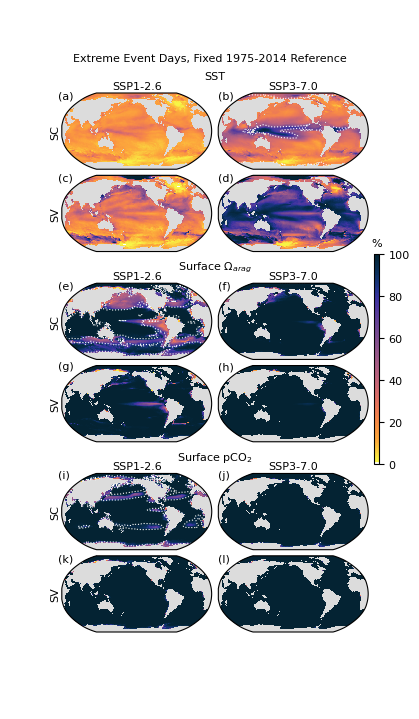

In [8]:
fig = plt.figure(figsize=(4, 7), constrained_layout=False)
og = fig.add_gridspec(3, 1, wspace=.08, hspace=.2)
axs={}
axt={}
iii=0
for b in range(3):
        # gridspec inside gridspec
        ig = og[b].subgridspec(2, 2, wspace=0.02, hspace=0.08)
        axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
        axt[iii]=fig.add_subplot(og[b])
        axt[iii].axis('off')
        iii+=1
cbax=fig.add_axes([.91,.35,.012,.3])
fig.suptitle(f'Extreme Event Days, Fixed 1975-2014 Reference',y=.937)

plot_sns(axs[0],axt[0],'tos',cbax)
plot_sns(axs[1],axt[1],'omega_arag_0')
#plot_sns(axs[2],axt[2],'hplusos')
plot_sns(axs[2],axt[2],'spco2')

axa=fig.add_axes(rect=[0,0,1,1])
axa.set_axis_off()
axa.annotate('(a)',xy=(0.12, 0.872))
axa.annotate('(b)',xy=(0.52, 0.872))
axa.annotate('(c)',xy=(0.12, 0.755))
axa.annotate('(d)',xy=(0.52, 0.755))
axa.annotate('(e)',xy=(0.12, 0.60))
axa.annotate('(f)',xy=(0.52, 0.60))
axa.annotate('(g)',xy=(0.12, 0.485))
axa.annotate('(h)',xy=(0.52, 0.485))
axa.annotate('(i)',xy=(0.12, 0.33))
axa.annotate('(j)',xy=(0.52, 0.33))
axa.annotate('(k)',xy=(0.12, 0.21))
axa.annotate('(l)',xy=(0.52, 0.21))

fig.savefig(f'global_extremes_seas_All_newcm.png',dpi=300,bbox_inches='tight')

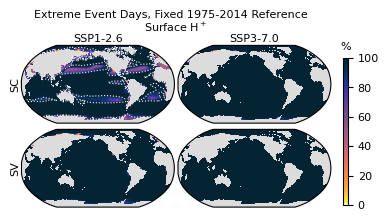

In [9]:
fig = plt.figure(figsize=(4, 2.1), constrained_layout=False)
og = fig.add_gridspec(1, 1, wspace=.09, hspace=.2)
axs={}
axt={}
iii=0
for b in range(1):
        # gridspec inside gridspec
        ig = og[b].subgridspec(2, 2, wspace=0.02, hspace=0.08)
        axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
        axt[iii]=fig.add_subplot(og[b])
        axt[iii].axis('off')
        iii+=1
cbax=fig.add_axes([.93,.12,.012,.7])
fig.suptitle(f'Extreme Event Days, Fixed 1975-2014 Reference',y=1.05)

plot_sns(axs[0],axt[0],'hplusos',cbax)
#plot_sns(axs[1],axt[1],'omega_arag_0')
#plot_sns(axs[2],axt[2],'hplusos')
#plot_sns(axs[2],axt[2],'spco2')
# axa=fig.add_axes(rect=[0,0,1,1])
# axa.set_axis_off()
# axa.annotate('(a)',xy=(0.12, 0.87))
# axa.annotate('(b)',xy=(0.52, 0.86))
# axa.annotate('(c)',xy=(0.12, 0.46))
# axa.annotate('(d)',xy=(0.52, 0.46))
fig.savefig(f'global_extremes_seas_All_newcm_hplus.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Seasonal\nThreshold')

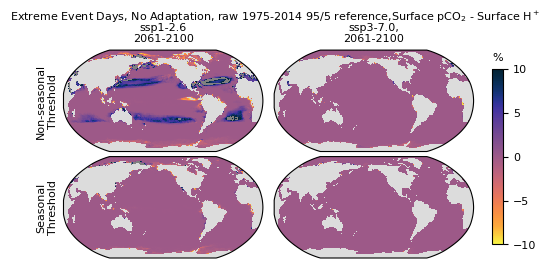

In [10]:
ivar1='hplusos'
ivar2='spco2'
fig,ax=plt.subplots(2,3,figsize=(5.7,2.7),gridspec_kw={'hspace':.05,'wspace':.05,
                                                   'width_ratios':[1,1,.1]},
                                      subplot_kw={'projection':proj,'facecolor':'gainsboro'})
for iax in ax[:,2]: iax.remove()
ax[0,2]=fig.add_axes([.88,.16,.02,.65])
#ax[1,3]=fig.add_axes([.87,.16,.02,.3])

ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                ff[ivar2,s126]['is_exA_sum']-ff[ivar1,s126]['is_exA_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
m=ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                  ff[ivar2,s370]['is_exA_sum']-ff[ivar1,s370]['is_exA_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
fig.colorbar(m,cax=ax[0,2]); ax[0,2].set_title('%')
ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                ff[ivar2,s126]['is_exD_sum']-ff[ivar1,s126]['is_exD_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
m=ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                  ff[ivar2,s370]['is_exD_sum']-ff[ivar1,s370]['is_exD_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
#fig.colorbar(m,cax=ax[1,3])
fig.suptitle(f'Extreme Event Days, No Adaptation, raw 1975-2014 95/5 reference,'
             f'{vstrs[ivar2]} - {vstrs[ivar1]}',y=1.03)



for iax in (ax[0,0],ax[0,1],ax[1,0],ax[1,1]):
    iax.set_xticks([])
    iax.set_yticks([])
ax[0,0].set_title('ssp1-2.6\n2061-2100')
ax[0,1].set_title('ssp3-7.0,\n2061-2100')
ax[0,0].set_ylabel('Non-seasonal\nThreshold')
ax[1,0].set_ylabel('Seasonal\nThreshold')



In [11]:

def plot_snsAdapt(ax,axti,ivar,cbax=None):
    cmin=1/(40*365)
    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[0,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exE100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    if cbax: fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=0,vmax=100), cmap=viz.cm1b),cax=cbax); cbax.set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exG100_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)

    #fig.suptitle(f'Extreme Event Days, 100-year Adaptation, raw 1975-2014 95/5 reference,'
    #             f'{vstrs[ivar]}',y=1.02)
    for iax in (ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('Historical',pad=3)
    ax[0,1].set_title('SSP1-2.6',pad=3)
    ax[0,2].set_title('ssp3-7.0')
    ax[0,0].set_ylabel('SC',labelpad=3)
    ax[1,0].set_ylabel('SV',labelpad=3)
    axti.set_title(vstrs[ivar],pad=13)#,loc='left')
    return

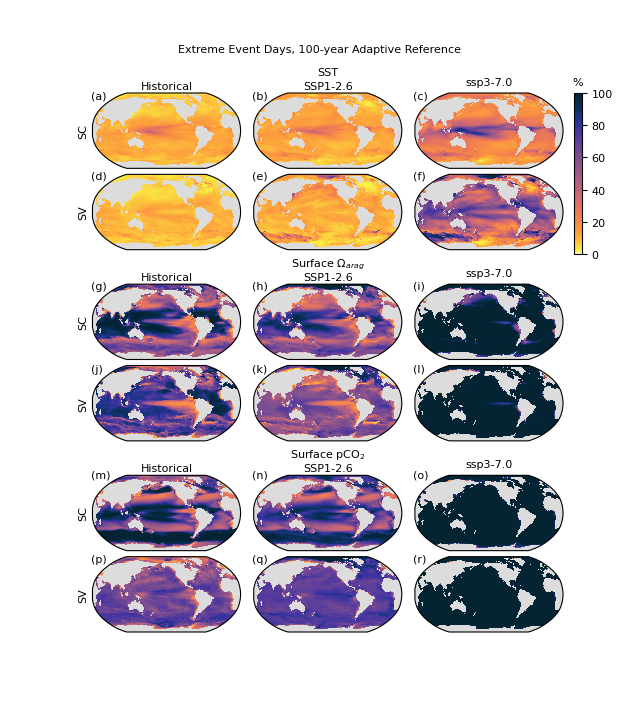

In [12]:
fig = plt.figure(figsize=(6.2, 7), constrained_layout=False)
og = fig.add_gridspec(3, 1, wspace=.08, hspace=.22)
axs={}
axt={}
iii=0
for b in range(3):
    # gridspec inside gridspec
    ig = og[b].subgridspec(2, 3, wspace=0.02, hspace=0.08)
    axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
    axt[iii]=fig.add_subplot(og[b])
    axt[iii].axis('off')
    iii+=1
cbax=fig.add_axes([.91,.65,.012,.23])

fig.suptitle(f'Extreme Event Days, 100-year Adaptive Reference',y=.95)

plot_snsAdapt(axs[0],axt[0],'tos',cbax)
plot_snsAdapt(axs[1],axt[1],'omega_arag_0')
plot_snsAdapt(axs[2],axt[2],'spco2')

axa=fig.add_axes(rect=[0,0,1,1])
axa.set_axis_off()
axa.annotate('(a)',xy=(0.13, 0.872))
axa.annotate('(b)',xy=(0.39, 0.872))
axa.annotate('(c)',xy=(0.65, 0.872))
axa.annotate('(d)',xy=(0.13, 0.758))
axa.annotate('(e)',xy=(0.39, 0.758))
axa.annotate('(f)',xy=(0.65, 0.758))
axa.annotate('(g)',xy=(0.13, 0.60))
axa.annotate('(h)',xy=(0.39, 0.60))
axa.annotate('(i)',xy=(0.65, 0.60))
axa.annotate('(j)',xy=(0.13, 0.482))
axa.annotate('(k)',xy=(0.39, 0.482))
axa.annotate('(l)',xy=(0.65, 0.482))
axa.annotate('(m)',xy=(0.13, 0.33))
axa.annotate('(n)',xy=(0.39, 0.33))
axa.annotate('(o)',xy=(0.65, 0.33))
axa.annotate('(p)',xy=(0.13, 0.21))
axa.annotate('(q)',xy=(0.39, 0.21))
axa.annotate('(r)',xy=(0.65, 0.21))
fig.savefig('global_extremes_seasAdapt_All_newcm.png',dpi=300,bbox_inches='tight')

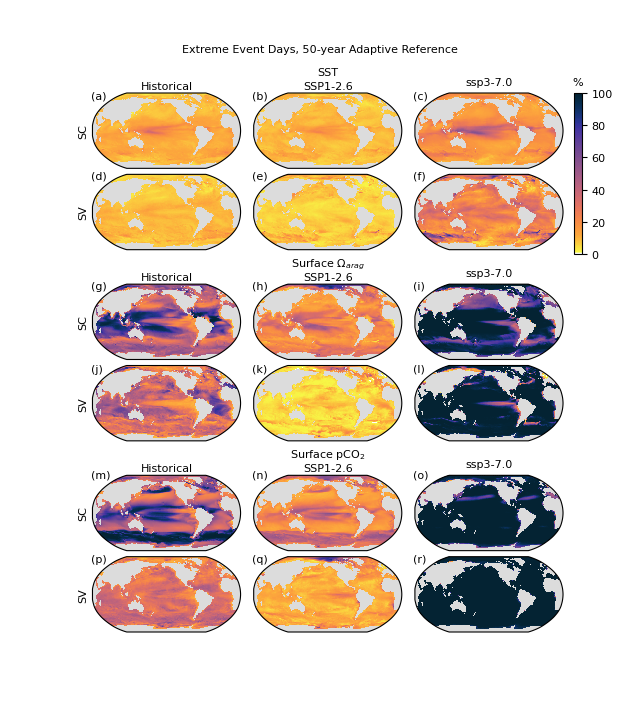

In [27]:
#50 years
def plot_snsAdapt50(ax,axti,ivar,cbax=None):
    cmin=1/(40*365)
    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exE_50_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exE_50_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[0,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exE_50_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    if cbax: fig.colorbar(mcm.ScalarMappable(norm=mcolors.Normalize(vmin=0,vmax=100), cmap=viz.cm1b),cax=cbax); cbax.set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,hist]['is_exG_50_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exG_50_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)
    m=ax[1,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exG_50_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=100,cmap=viz.cm1)

    #fig.suptitle(f'Extreme Event Days, 100-year Adaptation, raw 1975-2014 95/5 reference,'
    #             f'{vstrs[ivar]}',y=1.02)
    for iax in (ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('Historical',pad=3)
    ax[0,1].set_title('SSP1-2.6',pad=3)
    ax[0,2].set_title('ssp3-7.0')
    ax[0,0].set_ylabel('SC',labelpad=3)
    ax[1,0].set_ylabel('SV',labelpad=3)
    axti.set_title(vstrs[ivar],pad=13)#,loc='left')
    return

fig = plt.figure(figsize=(6.2, 7), constrained_layout=False)
og = fig.add_gridspec(3, 1, wspace=.08, hspace=.22)
axs={}
axt={}
iii=0
for b in range(3):
    # gridspec inside gridspec
    ig = og[b].subgridspec(2, 3, wspace=0.02, hspace=0.08)
    axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
    axt[iii]=fig.add_subplot(og[b])
    axt[iii].axis('off')
    iii+=1
cbax=fig.add_axes([.91,.65,.012,.23])

fig.suptitle(f'Extreme Event Days, 50-year Adaptive Reference',y=.95)

plot_snsAdapt50(axs[0],axt[0],'tos',cbax)
plot_snsAdapt50(axs[1],axt[1],'omega_arag_0')
plot_snsAdapt50(axs[2],axt[2],'spco2')

axa=fig.add_axes(rect=[0,0,1,1])
axa.set_axis_off()
axa.annotate('(a)',xy=(0.13, 0.872))
axa.annotate('(b)',xy=(0.39, 0.872))
axa.annotate('(c)',xy=(0.65, 0.872))
axa.annotate('(d)',xy=(0.13, 0.758))
axa.annotate('(e)',xy=(0.39, 0.758))
axa.annotate('(f)',xy=(0.65, 0.758))
axa.annotate('(g)',xy=(0.13, 0.60))
axa.annotate('(h)',xy=(0.39, 0.60))
axa.annotate('(i)',xy=(0.65, 0.60))
axa.annotate('(j)',xy=(0.13, 0.482))
axa.annotate('(k)',xy=(0.39, 0.482))
axa.annotate('(l)',xy=(0.65, 0.482))
axa.annotate('(m)',xy=(0.13, 0.33))
axa.annotate('(n)',xy=(0.39, 0.33))
axa.annotate('(o)',xy=(0.65, 0.33))
axa.annotate('(p)',xy=(0.13, 0.21))
axa.annotate('(q)',xy=(0.39, 0.21))
axa.annotate('(r)',xy=(0.65, 0.21))
fig.savefig('global_extremes_seasAdapt50_All_newcm.png',dpi=300,bbox_inches='tight')

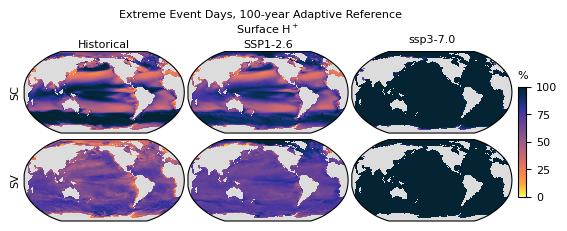

In [14]:
fig = plt.figure(figsize=(6.3, 2.2), constrained_layout=False)
og = fig.add_gridspec(1, 1, wspace=.08, hspace=.2)
axs={}
axt={}
iii=0
for b in range(1):
    # gridspec inside gridspec
    ig = og[b].subgridspec(2, 3, wspace=0.02, hspace=0.08)
    axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
    axt[iii]=fig.add_subplot(og[b])
    axt[iii].axis('off')
    iii+=1
cbax=fig.add_axes([.91,.22,.012,.5])

fig.suptitle(f'Extreme Event Days, 100-year Adaptive Reference',y=1.07)

plot_snsAdapt(axs[0],axt[0],'hplusos',cbax)
#cbax.remove()
# axa=fig.add_axes(rect=[0,0,1,1])
# axa.set_axis_off()
# axa.annotate('(a)',xy=(0.13, 0.855))
# axa.annotate('(b)',xy=(0.39, 0.855))
# axa.annotate('(c)',xy=(0.65, 0.855))
# axa.annotate('(d)',xy=(0.13, 0.455))
# axa.annotate('(e)',xy=(0.39, 0.455))
# axa.annotate('(f)',xy=(0.65, 0.455))
fig.savefig('global_extremes_seasAdapt_All_newcm_hplusos.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'SV')

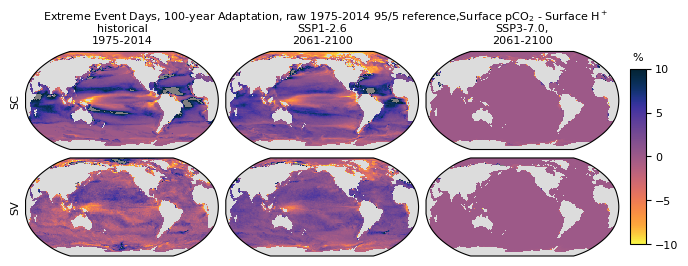

In [15]:
ivar1='hplusos'
ivar2='spco2'
cb=True
fig,ax=plt.subplots(2,4,figsize=(8,2.7),gridspec_kw={'hspace':.05,'wspace':.05,
                                                   'width_ratios':[1,1,1,.1]},
                                      subplot_kw={'projection':proj,'facecolor':'gainsboro'})
for iax in ax[:,3]: iax.remove()
if cb: ax[0,3]=fig.add_axes([.88,.16,.02,.65])
#ax[1,3]=fig.add_axes([.87,.16,.02,.3])

ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                ff[ivar2,hist]['is_exE100_sum']-ff[ivar1,hist]['is_exE100_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                ff[ivar2,s126]['is_exE100_sum']-ff[ivar1,s126]['is_exE100_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
m=ax[0,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                  ff[ivar2,s370]['is_exE100_sum']-ff[ivar1,s370]['is_exE100_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
if cb: fig.colorbar(m,cax=ax[0,3]); ax[0,3].set_title('%')
ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                ff[ivar2,hist]['is_exG100_sum']-ff[ivar1,hist]['is_exG100_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                ff[ivar2,s126]['is_exG100_sum']-ff[ivar1,s126]['is_exG100_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
m=ax[1,2].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                  ff[ivar2,s370]['is_exG100_sum']-ff[ivar1,s370]['is_exG100_sum'])/(365*40)*100,
                   transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=viz.cm2)
#fig.colorbar(m,cax=ax[1,3])
fig.suptitle(f'Extreme Event Days, 100-year Adaptation, raw 1975-2014 95/5 reference,'
             f'{vstrs[ivar2]} - {vstrs[ivar1]}',y=1.03)

for iax in (ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]):
    iax.set_xticks([])
    iax.set_yticks([])
ax[0,0].set_title('historical\n1975-2014')
ax[0,1].set_title('SSP1-2.6\n2061-2100')
ax[0,2].set_title('SSP3-7.0,\n2061-2100')
ax[0,0].set_ylabel('SC')
ax[1,0].set_ylabel('SV')


# plot stress criteria

In [16]:
cmamp=plt.get_cmap('Oranges')
cmamp.set_bad('w',alpha=0)

In [17]:
cmin=0
cmax={'tos':[12,6],'omega_arag_0':[1.2,.6],'hplusos':[0.004,0.002],'spco2':[20,10]}
def plot_sns_th(ivar):
    fig,ax=plt.subplots(1,2,figsize=(5.7,1.4),gridspec_kw={'hspace':.01,'wspace':.07,
                                                       'width_ratios':[1,1]},
                                          subplot_kw={'projection':proj,'facecolor':'gainsboro'})

    m=ax[0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                            sf[ivar]['qt'].sel(quantile=.95).data-sf[ivar]['mean'].data[0,:,:]),
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=cmax[ivar][0],cmap=cmamp)
    fig.colorbar(m,ax=ax[0],extend='max',ticks=np.linspace(cmin,cmax[ivar][0],3),shrink=.8)
    m=ax[1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                            sf[ivar]['qt_ds'].sel(quantile=.95).values-sf[ivar]['mean'].data[0,:,:]),
                       transform=ccrs.PlateCarree(),vmin=cmin,vmax=cmax[ivar][1],cmap=cmamp)
    fig.colorbar(m,ax=ax[1],extend='max',ticks=np.linspace(cmin,cmax[ivar][1],3),shrink=.8)
    fig.suptitle(f'Threshold Amplitude, raw 1975-2014 95/5 reference, '
                 f'{vstrs[ivar]}',y=1.02)
    ax[0].set_title('Seasonally Constant')
    ax[1].set_title('Seasonally Varying')
    fig2,ax2=plt.subplots(1,1,figsize=(3,1.7))
    mm=ax2.pcolormesh((sf[ivar]['qt'].sel(quantile=.95).data-sf[ivar]['mean'].data[0,:,:])/\
              (sf[ivar]['qt_ds'].sel(quantile=.95).values-sf[ivar]['mean'].data[0,:,:]),vmin=1,vmax=3)
    ax2.contour((sf[ivar]['qt'].sel(quantile=.95).data-sf[ivar]['mean'].data[0,:,:])/\
              (sf[ivar]['qt_ds'].sel(quantile=.95).values-sf[ivar]['mean'].data[0,:,:]),[2],colors='w')
    fig2.colorbar(mm)

    for iax in ax:
        iax.set_xticks([])
        iax.set_yticks([])
    return fig,ax


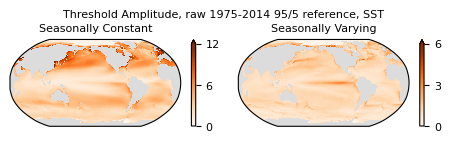

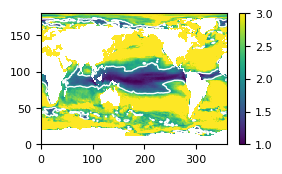

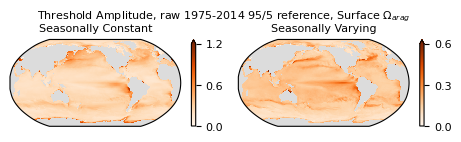

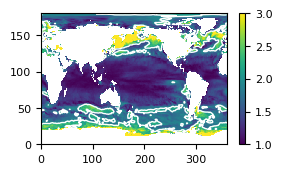

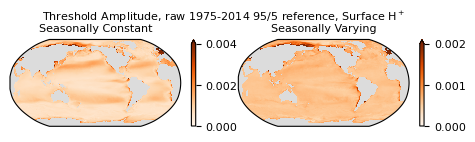

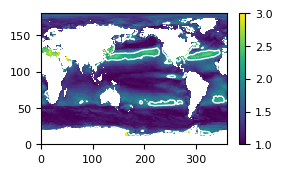

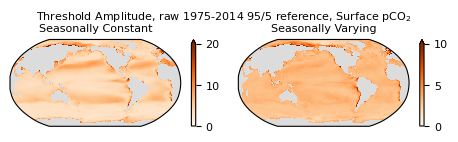

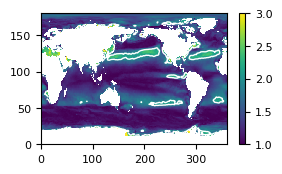

In [18]:
for ivar in ['tos','omega_arag_0','hplusos','spco2']:
    fig,ax=plot_sns_th(ivar)
#     fig.savefig(f'thresholds_fixed_{ivar}_newcm.png',dpi=300,bbox_inches='tight')

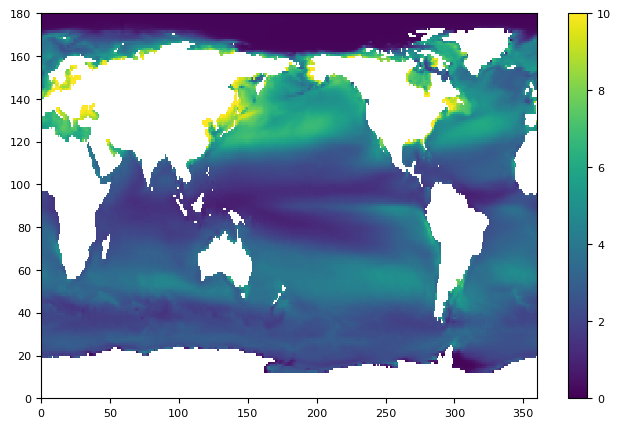

In [19]:
plt.pcolormesh(sf['tos']['qt'].sel(quantile=.95).data-sf['tos']['mean'].data[0,:,:],vmin=0,vmax=10)
plt.colorbar()

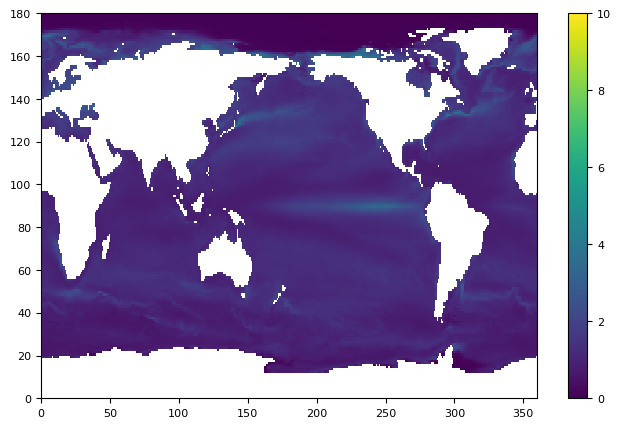

In [20]:
plt.pcolormesh(sf['tos']['qt_ds'].sel(quantile=.95).values-sf['tos']['mean'].data[0,:,:],vmin=0,vmax=10)
plt.colorbar()

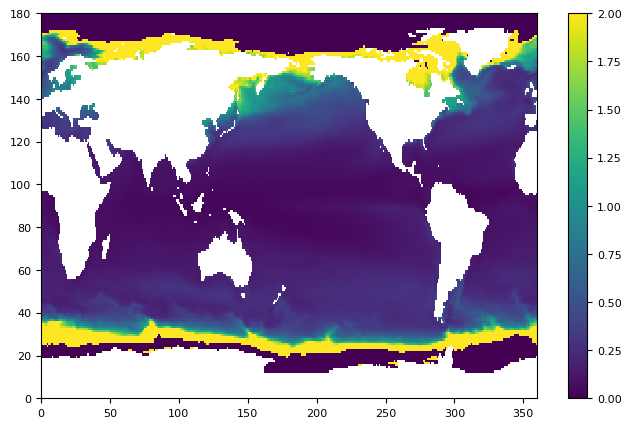

In [21]:
plt.pcolormesh((sf['tos']['qt'].sel(quantile=.95).data-sf['tos']['mean'].data[0,:,:])/sf['tos']['qt_ds'].sel(quantile=.95).values,vmin=0,vmax=2)
plt.colorbar()

In [22]:
np.shape(sf['tos']['mean'].data)

(1, 180, 360)

In [23]:
def plot_sns_diff_adapt(ax,axti,ivar,cbax=None):
    vmax=40
    ax[0,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exE100_sum']-ff[ivar,s126]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),norm=mcolors.CenteredNorm(0,vmax), cmap=cmocean.cm.balance)
    m=ax[0,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exE100_sum']-ff[ivar,s370]['is_exA_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),norm=mcolors.CenteredNorm(0,vmax), cmap=cmocean.cm.balance)
    if cbax: fig.colorbar(mcm.ScalarMappable(norm=mcolors.CenteredNorm(0,vmax), cmap=cmocean.cm.balance),cax=cbax,extend='both'); cbax.set_title('%') #fig.colorbar(m,cax=cbax); cbax.set_title('%')
    ax[1,0].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                    ff[ivar,s126]['is_exG100_sum']-ff[ivar,s126]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),norm=mcolors.CenteredNorm(0,vmax), cmap=cmocean.cm.balance)
    m=ax[1,1].pcolormesh(lons,lats,np.ma.masked_where(viz.wet1x1==0,
                                                      ff[ivar,s370]['is_exG100_sum']-ff[ivar,s370]['is_exD_sum'])/(365*40)*100,
                       transform=ccrs.PlateCarree(),norm=mcolors.CenteredNorm(0,vmax), cmap=cmocean.cm.balance)
    for iax in (ax[0,0],ax[0,1],ax[1,0],ax[1,1]):
        iax.set_xticks([])
        iax.set_yticks([])
    ax[0,0].set_title('SSP1-2.6',pad=3)
    ax[0,1].set_title('SSP3-7.0',pad=3)
    ax[0,0].set_ylabel('SC',labelpad=1)
    ax[1,0].set_ylabel('SV',labelpad=1)
    axti.set_title(vstrs[ivar],pad=10)
    return

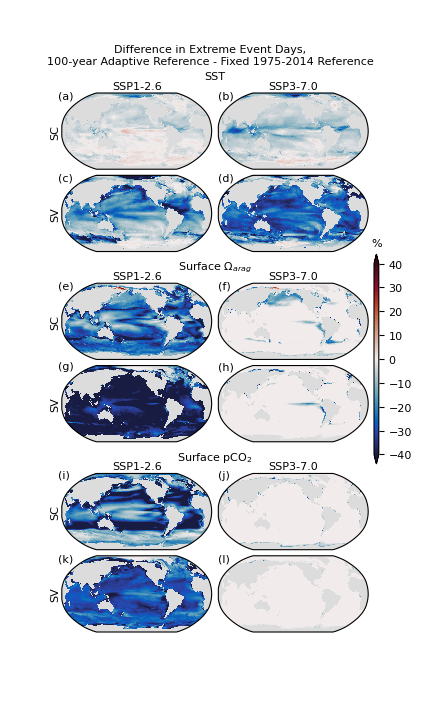

In [24]:
fig = plt.figure(figsize=(4, 7), constrained_layout=False)
og = fig.add_gridspec(3, 1, wspace=.08, hspace=.2)
axs={}
axt={}
iii=0
for b in range(3):
        # gridspec inside gridspec
        ig = og[b].subgridspec(2, 2, wspace=0.02, hspace=0.08)
        axs[iii] = ig.subplots(subplot_kw={'projection':proj,'facecolor':'gainsboro'})
        axt[iii]=fig.add_subplot(og[b])
        axt[iii].axis('off')
        iii+=1
cbax=fig.add_axes([.91,.35,.012,.3])
fig.suptitle(f'Difference in Extreme Event Days,\n100-year Adaptive Reference - Fixed 1975-2014 Reference',y=.95)

plot_sns_diff_adapt(axs[0],axt[0],'tos',cbax)
plot_sns_diff_adapt(axs[1],axt[1],'omega_arag_0')
plot_sns_diff_adapt(axs[2],axt[2],'spco2')

axa=fig.add_axes(rect=[0,0,1,1])
axa.set_axis_off()
axa.annotate('(a)',xy=(0.12, 0.872))
axa.annotate('(b)',xy=(0.52, 0.872))
axa.annotate('(c)',xy=(0.12, 0.755))
axa.annotate('(d)',xy=(0.52, 0.755))
axa.annotate('(e)',xy=(0.12, 0.60))
axa.annotate('(f)',xy=(0.52, 0.60))
axa.annotate('(g)',xy=(0.12, 0.485))
axa.annotate('(h)',xy=(0.52, 0.485))
axa.annotate('(i)',xy=(0.12, 0.33))
axa.annotate('(j)',xy=(0.52, 0.33))
axa.annotate('(k)',xy=(0.12, 0.21))
axa.annotate('(l)',xy=(0.52, 0.21))

fig.savefig(f'global_extremes_seas_All_newcm_adapt_minus_fixed.png',dpi=300,bbox_inches='tight')

In [25]:
ffi=ff['omega_arag_0','ESM4_historical_D1']
wgt=xr.DataArray(data=viz.areacello1x1,
            coords={'lat': ffi.lat,'lon': ffi.lon}, 
            dims=["lat", "lon"])#.stack(xy=['lat','lon'])
wgt=wgt*1e-6 # convert m2 to km2

In [26]:
for ivar in ['tos','omega_arag_0','spco2','hplusos']:
    print(ivar)
    for iscen in ['ESM4_ssp126_D1','ESM4_ssp370_D1']:
        SCdiff=ff[ivar,iscen]['is_exE100_sum']-ff[ivar,iscen]['is_exA_sum']
        SVdiff=ff[ivar,iscen]['is_exG100_sum']-ff[ivar,iscen]['is_exD_sum']
        meanSCdiff=np.ma.masked_where(viz.wet1x1==0,SCdiff*wgt).sum()/np.ma.masked_where(viz.wet1x1==0,wgt).sum()
        meanSVdiff=np.ma.masked_where(viz.wet1x1==0,SVdiff*wgt).sum()/np.ma.masked_where(viz.wet1x1==0,wgt).sum()
        print(f'{ivar:15} {iscen:15} SC: {meanSCdiff:.1f} days, {meanSCdiff/(40*365)*100:.1f}%')
        print(f'{ivar:15} {iscen:15} SV: {meanSVdiff:.1f} days, {meanSVdiff/(40*365)*100:.1f}%')

tos
tos             ESM4_ssp126_D1  SC: -361.6 days, -2.5%
tos             ESM4_ssp126_D1  SV: -2316.3 days, -15.9%
tos             ESM4_ssp370_D1  SC: -926.8 days, -6.3%
tos             ESM4_ssp370_D1  SV: -3538.5 days, -24.2%
omega_arag_0
omega_arag_0    ESM4_ssp126_D1  SC: -3399.0 days, -23.3%
omega_arag_0    ESM4_ssp126_D1  SV: -6182.5 days, -42.3%
omega_arag_0    ESM4_ssp370_D1  SC: -237.2 days, -1.6%
omega_arag_0    ESM4_ssp370_D1  SV: -94.6 days, -0.6%
spco2
spco2           ESM4_ssp126_D1  SC: -3859.0 days, -26.4%
spco2           ESM4_ssp126_D1  SV: -4141.7 days, -28.4%
spco2           ESM4_ssp370_D1  SC: -49.9 days, -0.3%
spco2           ESM4_ssp370_D1  SV: -10.7 days, -0.1%
hplusos
hplusos         ESM4_ssp126_D1  SC: -3989.0 days, -27.3%
hplusos         ESM4_ssp126_D1  SV: -4335.2 days, -29.7%
hplusos         ESM4_ssp370_D1  SC: -47.8 days, -0.3%
hplusos         ESM4_ssp370_D1  SV: -9.5 days, -0.1%
